In [299]:
import os
os.chdir("C:\\Users\\Zber\\Documents\\Dev_program\\OpenRadar")

import sys
import numpy as np
import mmwave.dsp as dsp
import mmwave.clustering as clu
from mmwave.dataloader import DCA1000
from demo.visualizer.visualize import ellipse_visualize
from scipy import signal
from mmwave.dsp.utils import Window
import math
from operator import add
from scipy.signal import butter, lfilter
import matplotlib.pyplot as plt
from FER.utils import parseConfigFile, arange_tx
from mmwave.dsp.cfar import ca

# plotting color
import matplotlib._color_data as mcd

# configure file path
# configFileName = 'C:/Users/Zber/Desktop/mmWave Configuration/profile_3d_aop_30s.cfg'
configFileName = 'C:/Users/Zber/Desktop/mmWave Configuration/profile_3d_aop_30s_20fps.cfg'

In [300]:
def butter_bandpass_fs(sig, lowcut, highcut, fs):
    sos = signal.butter(4, [lowcut, highcut], 'bandpass', fs=fs, analog=False, output='sos')
    filtered = signal.sosfilt(sos, sig)
    return filtered

def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [162]:
# file path
# adc_data_path = "D:/Subjects/Distance_100cm/Neutral_1_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Heartbeat/Heartbeat_0_Raw_0.bin"
# adc_data_path_1 = "C:/Users/Zber/Desktop/Subjects/Heartbeat/Heartbeat_0_Raw_1.bin"
adc_data_path = "C:/Users/Zber/Desktop/Subjects/Heartbeat/Heartbeat_2_Raw_0.bin"

In [183]:
configFileName = 'C:/Users/Zber/Desktop/mmWave Configuration/profile_3d_aop_3s.cfg'
adc_data_path = "C:/Users/Zber/Desktop/Subjects/Multi_People/Surprise_100cm_fan_movePeople_9_Raw_0.bin"

In [184]:
# num Antennas
numTxAntennas = 3
numRxAntennas = 4
# load configure parameters
configParameters = parseConfigFile(configFileName)

# mmWave radar settings
numFrames = configParameters['numFrames']
numADCSamples = configParameters['numAdcSamples']
numLoopsPerFrame = configParameters['numLoops']
numChirpsPerFrame = numTxAntennas * numLoopsPerFrame
numAngleBins = 64

# data processing parameter
range_resolution, bandwidth = dsp.range_resolution(numADCSamples,
                                                    dig_out_sample_rate=configParameters['digOutSampleRate'],
                                                    freq_slope_const=configParameters['freqSlopeConst'])
doppler_resolution = dsp.doppler_resolution(bandwidth, start_freq_const=configParameters['startFreq'],
                                            ramp_end_time=configParameters['rampEndTime'],
                                            idle_time_const=configParameters['idleTime'],
                                            num_loops_per_frame=configParameters['numLoops'],
                                            num_tx_antennas=numTxAntennas)

print('Range Resolution: {:.2f}cm, Bandwidth: {:.2f}Ghz, Doppler Resolution: {:.2f}m/s'.format(
    range_resolution * 100, bandwidth / 1000000000, doppler_resolution))

Range Resolution: 4.22cm, Bandwidth: 3.56Ghz, Doppler Resolution: 0.43m/s


In [ ]:
# load file and range processing
# (1) Reading in adc data
adc_data = np.fromfile(adc_data_path, dtype=np.int16)
adc_data_1 = np.fromfile(adc_data_path_1, dtype=np.int16)

adc_data= np.concatenate([adc_data, adc_data_1])

adc_data = adc_data.reshape(numFrames, -1)
adc_data = np.apply_along_axis(DCA1000.organize_cli, 1, adc_data, num_chirps=numChirpsPerFrame,
                                num_rx=numRxAntennas, num_samples=numADCSamples)
print("Data Loaded!")

# range processing
range_data = dsp.range_processing(adc_data)
# range_data = dsp.range_processing(adc_data, window_type_1d=Window.HANNING)
range_data = arange_tx(range_data, num_tx=numTxAntennas)

In [185]:
# load file and range processing
# (1) Reading in adc data
adc_data = np.fromfile(adc_data_path, dtype=np.int16)
adc_data = adc_data.reshape(numFrames, -1)
adc_data = np.apply_along_axis(DCA1000.organize_cli, 1, adc_data, num_chirps=numChirpsPerFrame,
                                num_rx=numRxAntennas, num_samples=numADCSamples)
print("Data Loaded!")

# range processing
range_data = dsp.range_processing(adc_data)
# range_data = dsp.range_processing(adc_data, window_type_1d=Window.HANNING)
range_data = arange_tx(range_data, num_tx=numTxAntennas)

Data Loaded!


(300, 32, 12, 256)


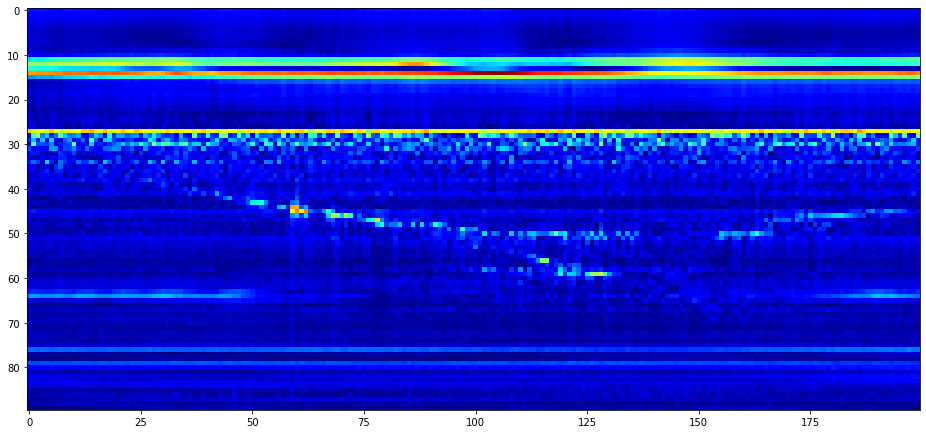

In [186]:
# range profile
print(range_data.shape)
fig5, axes5 = plt.subplots(1, 1, figsize=(16, 9))
# range_plot_data = np.mean(range_data[:,:,:,:100],axis=(1,2))
range_plot_data = np.mean(range_data[50:250,15,:,10:100],axis=(1))
# range_plot_data = np.mean(range_data,axis=(1,2))
# range_plot_data = range_data[:,15,2,:50]
axes5.imshow(np.abs(range_plot_data.T), cmap=plt.get_cmap('jet'))

30
18


c:\Users\Zber\anaconda3\envs\Emo\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


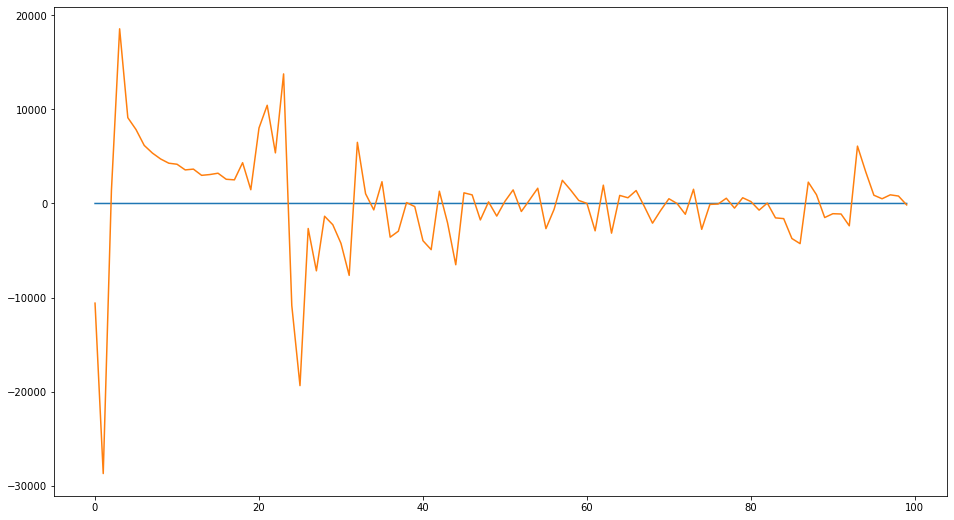

In [187]:
fig7, axes7 = plt.subplots(1, 1, figsize=(16, 9))
# range_plot_data = np.mean(range_data[50:250,15,4,:100],axis=(1))
range_plot_data = range_data[50:250,15,4,:100]

log_range_data = np.log10(range_plot_data) * 20

amp_phase = np.mean(range_plot_data, axis=0)

variance_phase = np.std(np.angle(range_plot_data), axis=0)
axes7.plot(variance_phase)

max_index = np.argmax(variance_phase) 
print(max_index)

max_amp_index = np.argmax(amp_phase[5:])
print(max_amp_index)
axes7.plot(amp_phase)

In [188]:
subject_bid = 23
fan_bid = 40
wall_bid = 87

[24 38 39 40 41 42 43 44 59 60]


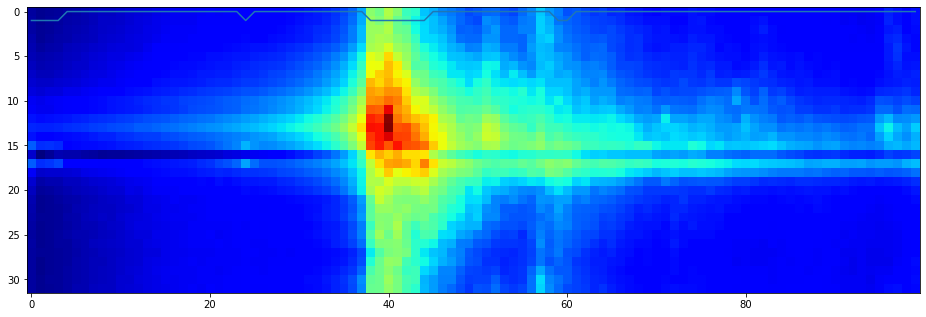

In [51]:
# %matplotlib widget
s_bin = 0
e_bin = s_bin + 100
# %matplotlib inline
fig, axes = plt.subplots(1, 1, figsize=(16, 9))
det_matrix, aoa_input = dsp.doppler_processing_frame(range_data, num_tx_antennas=numTxAntennas,
                                                    clutter_removal_enabled=True,
                                                    window_type_2d=Window.HAMMING,
                                                    accumulate=True)

# det_matrix, aoa_input = doppler_processing(range_data, num_tx_antennas=numTxAntennas,
#                                                     clutter_removal_enabled=True,
#                                                     window_type_2d=Window.HAMMING,
#                                                     accumulate=True)

det_matrix_vis = np.fft.fftshift(det_matrix, axes=2)
det_matrix_vis_mean = np.mean(det_matrix_vis[:, :, :], axis=0)
# det_matrix_vis_mean = np.mean(det_matrix_vis[50:100, :, :], axis=0)
bin_data = det_matrix_vis_mean[:, 17] + det_matrix_vis_mean[:, 15]

peak_data = ca(bin_data, guard_len=2, noise_len=4, l_bound=8)[s_bin:e_bin]

axes.plot(peak_data)
# axes.axvline(x=20, color='r', linestyle='-')
# axes.axvline(x=24, color='r', linestyle='-')

axes.imshow(np.abs(det_matrix_vis_mean.T[:,s_bin:e_bin]), cmap=plt.get_cmap('jet'))
det_matrix_vis.shape
offset = 5
peak_data = peak_data[offset:offset+200]
detect_pos = np.where(peak_data == True)[0]
detect_pos += offset
print(detect_pos)

In [75]:
range_data.shape

(300, 32, 12, 256)

In [218]:
chirp_index=15
v_antenna_index=5
# phase_data = np.mean(np.angle(range_data[:, chirp_index:, v_antenna_index, bin_index]), axis=(1))
phase_data = np.angle(range_data[:, chirp_index, v_antenna_index, subject_bid])
# unwrap_phase = np.unwrap(2*phase_data, discont=0.1)/2
unwrap_phase = np.unwrap(phase_data, axis=0)
# unwrap_phase = np.mean(unwrap_phase, axis=(1,2))
# unwrap_phase = unwrap_phase[::5]
subject_phase = np.diff(unwrap_phase)
# fft_phase = np.fft.fft(diff_phase)

In [219]:
chirp_index=15
v_antenna_index=5
# phase_data = np.mean(np.angle(range_data[:, chirp_index:, v_antenna_index, bin_index]), axis=(1))
w_phase_data = np.angle(range_data[:, chirp_index, v_antenna_index, wall_bid])
# unwrap_phase = np.unwrap(2*phase_data, discont=0.1)/2
w_unwrap_phase = np.unwrap(w_phase_data, axis=0)
# unwrap_phase = np.mean(unwrap_phase, axis=(1,2))
# unwrap_phase = unwrap_phase[::5]
wall_phase = np.diff(w_unwrap_phase)

In [220]:
chirp_index=15
v_antenna_index=5
# phase_data = np.mean(np.angle(range_data[:, chirp_index:, v_antenna_index, bin_index]), axis=(1))
f_phase_data = np.angle(range_data[:, chirp_index, v_antenna_index, fan_bid])
# unwrap_phase = np.unwrap(2*phase_data, discont=0.1)/2
f_unwrap_phase = np.unwrap(f_phase_data, axis=0)
# unwrap_phase = np.mean(unwrap_phase, axis=(1,2))
# unwrap_phase = unwrap_phase[::5]
fan_phase = np.diff(f_unwrap_phase)

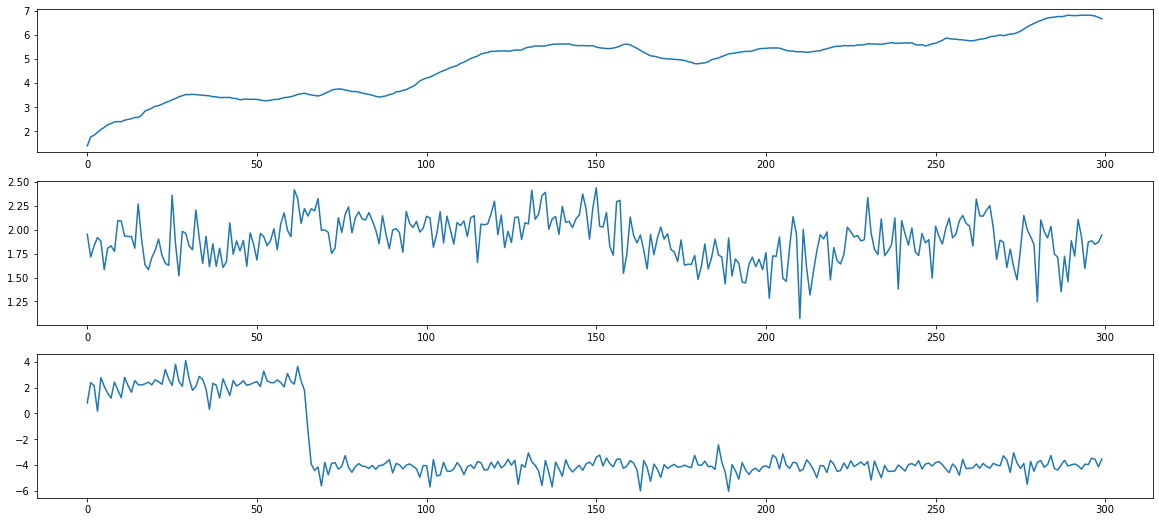

In [221]:
fig01, ax01 = plt.subplots(3, 1, figsize=(20, 9))
ax01[0].plot(unwrap_phase)
ax01[1].plot(w_unwrap_phase)
ax01[2].plot(f_unwrap_phase)

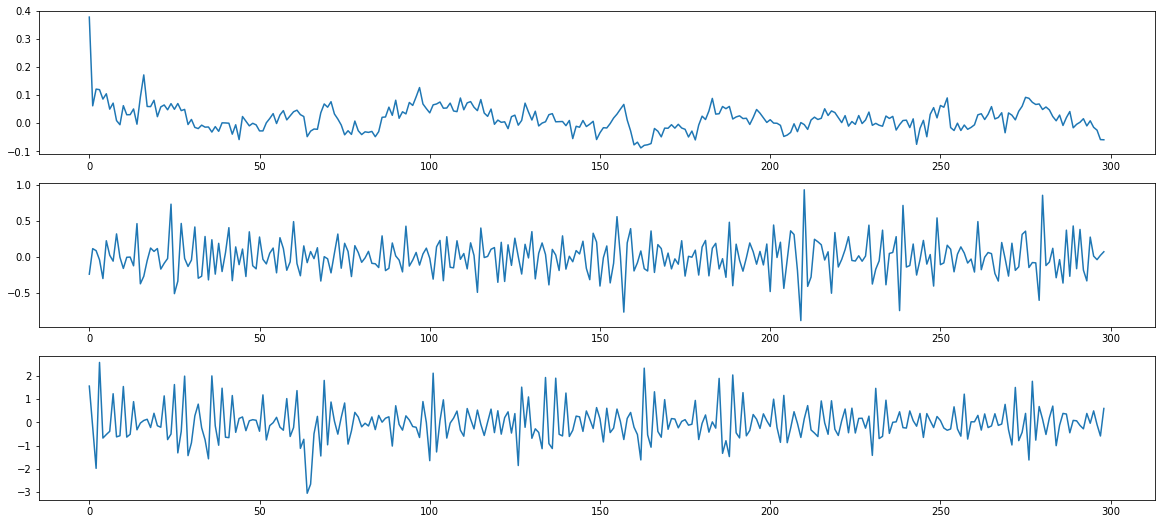

In [222]:
fig02, ax02 = plt.subplots(3, 1, figsize=(20, 9))
ax02[0].plot(subject_phase)
ax02[1].plot(wall_phase)
ax02[2].plot(fan_phase)

In [293]:
hb_l, hb_h = 0.8, 2.0
b_l, b_h = 0.05, 0.5
ffs = 100
s_hb_signal = butter_bandpass_fs(subject_phase, lowcut=hb_l, highcut=hb_h, fs=ffs) * 5
s_breath_signal = butter_bandpass_fs(subject_phase, lowcut=b_l, highcut=b_h, fs=ffs) * 20

w_hb_signal = butter_bandpass_fs(wall_phase, lowcut=b_l, highcut=b_h, fs=ffs) * 5
w_breath_signal = butter_bandpass_fs(wall_phase, lowcut=b_l, highcut=b_h, fs=ffs) * 10

f_hb_signal = butter_bandpass_fs(fan_phase, lowcut=b_l, highcut=b_h, fs=ffs) 
f_breath_signal = butter_bandpass_fs(fan_phase, lowcut=b_l, highcut=b_h, fs=ffs) 

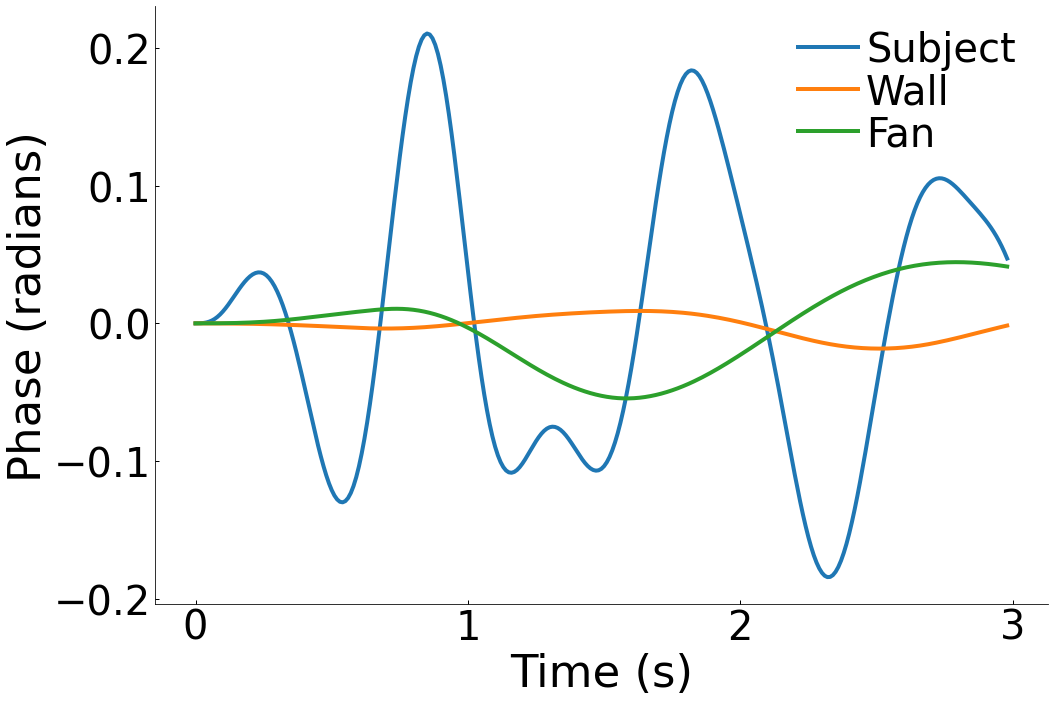

In [309]:
fig2, ax2 = plt.subplots(1, 1, figsize=(16, 11))
lw = 4
ax2.plot(s_hb_signal, label='Subject', linewidth=lw)
ax2.plot(w_hb_signal, label='Wall', linewidth=lw)
ax2.plot(f_hb_signal, label='Fan', linewidth=lw)

ax2.set_xlabel("Time (s)",fontsize=45)
ax2.set_ylabel("Phase (radians)",fontsize=45)


y_txt = np.arange(0,4, step=1)
y_pos = y_txt*100

ax2.set_xticks(y_pos)
ax2.set_xticklabels(y_txt,fontsize=40)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.yaxis.set_tick_params(labelsize=40, length=4, direction='in', width=1)
ax2.xaxis.set_tick_params(labelsize=40, length=4, direction='in', width=1)
ax2.legend(loc="upper left", prop={'size': 40, }, ncol=1, bbox_to_anchor=(0.68, 1.02), fancybox=True,
               framealpha=0.0, labelspacing=0.05, handletextpad=0.2, columnspacing=0.5, handlelength=1.5)
               
fig2.savefig('C:/Users/Zber/Desktop/mmEmo_Exp/0.Method/m1_4_heartbeat.svg', format='svg', bbox_inches="tight")

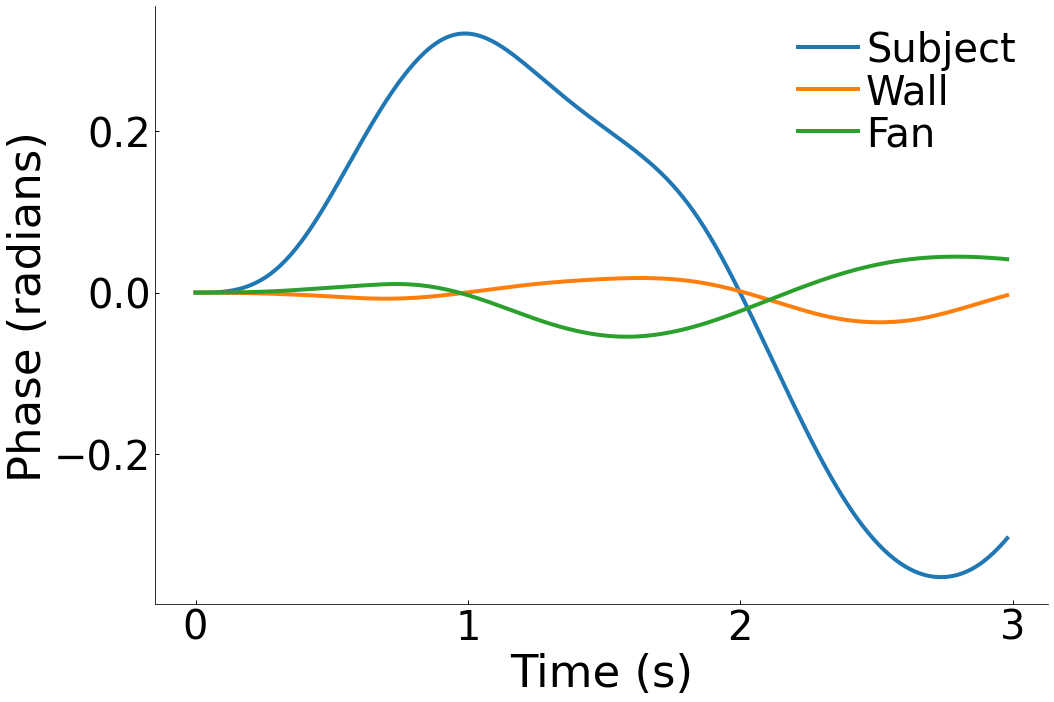

In [308]:
fig3, ax3 = plt.subplots(1, 1, figsize=(16, 11))
lw = 4
ax3.plot(s_breath_signal, label='Subject', linewidth=lw)
ax3.plot(w_breath_signal, label='Wall', linewidth=lw)
ax3.plot(f_breath_signal, label='Fan', linewidth=lw)

ax3.set_xlabel("Time (s)",fontsize=45)
ax3.set_ylabel("Phase (radians)",fontsize=45)


y_txt = np.arange(0,4, step=1)
y_pos = y_txt*100

ax3.set_xticks(y_pos)
ax3.set_xticklabels(y_txt,fontsize=40)

ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.yaxis.set_tick_params(labelsize=40, length=4, direction='in', width=1)
ax3.xaxis.set_tick_params(labelsize=40, length=4, direction='in', width=1)
ax3.legend(loc="upper left", prop={'size': 40, }, ncol=1, bbox_to_anchor=(0.68, 1.02), fancybox=True,
               framealpha=0.0, labelspacing=0.05, handletextpad=0.2, columnspacing=0.5, handlelength=1.5)

fig3.savefig('C:/Users/Zber/Desktop/mmEmo_Exp/0.Method/m1_4_breath.svg', format='svg', bbox_inches="tight")